<a href="https://colab.research.google.com/github/nimendra-ag/brain_tumor_detection_algo/blob/main/Brain_tumor_Tensorflow_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
from PIL import Image
import zipfile
import tensorflow_probability as tfp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.regularizers import L2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Neural Network imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomContrast, RandomZoom, RandomFlip

# Training Model callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ReduceLROnPlateau

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# !kaggle datasets list

In [ ]:
# ! kaggle datasets download 'mohammadhossein77/brain-tumors-dataset'

In [ ]:
! kaggle datasets download 'rm1000/brain-tumor-mri-scans'

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 98% 231M/236M [00:01<00:00, 102MB/s]
100% 236M/236M [00:01<00:00, 128MB/s]


In [ ]:
# Define the zip file name and the extraction path
zip_file = "brain-tumor-mri-scans.zip"
extract_path = "brain-tumor-mri-scans"

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
dataset_path = "brain-tumor-mri-scans"


In [ ]:
# List the subdirectories (which represent the labels/classes)
classes = os.listdir(dataset_path)
classes

['glioma', 'pituitary', 'healthy', 'meningioma']

In [ ]:
class_counts = {}
for label in classes:
    label_path = os.path.join(dataset_path, label)
    print(label_path)
    images = os.listdir(label_path)
    print(len(images))
    class_counts[label] = len(images)
print(class_counts)

brain-tumor-mri-scans/glioma
1621
brain-tumor-mri-scans/pituitary
1757
brain-tumor-mri-scans/healthy
2000
brain-tumor-mri-scans/meningioma
1645
{'glioma': 1621, 'pituitary': 1757, 'healthy': 2000, 'meningioma': 1645}


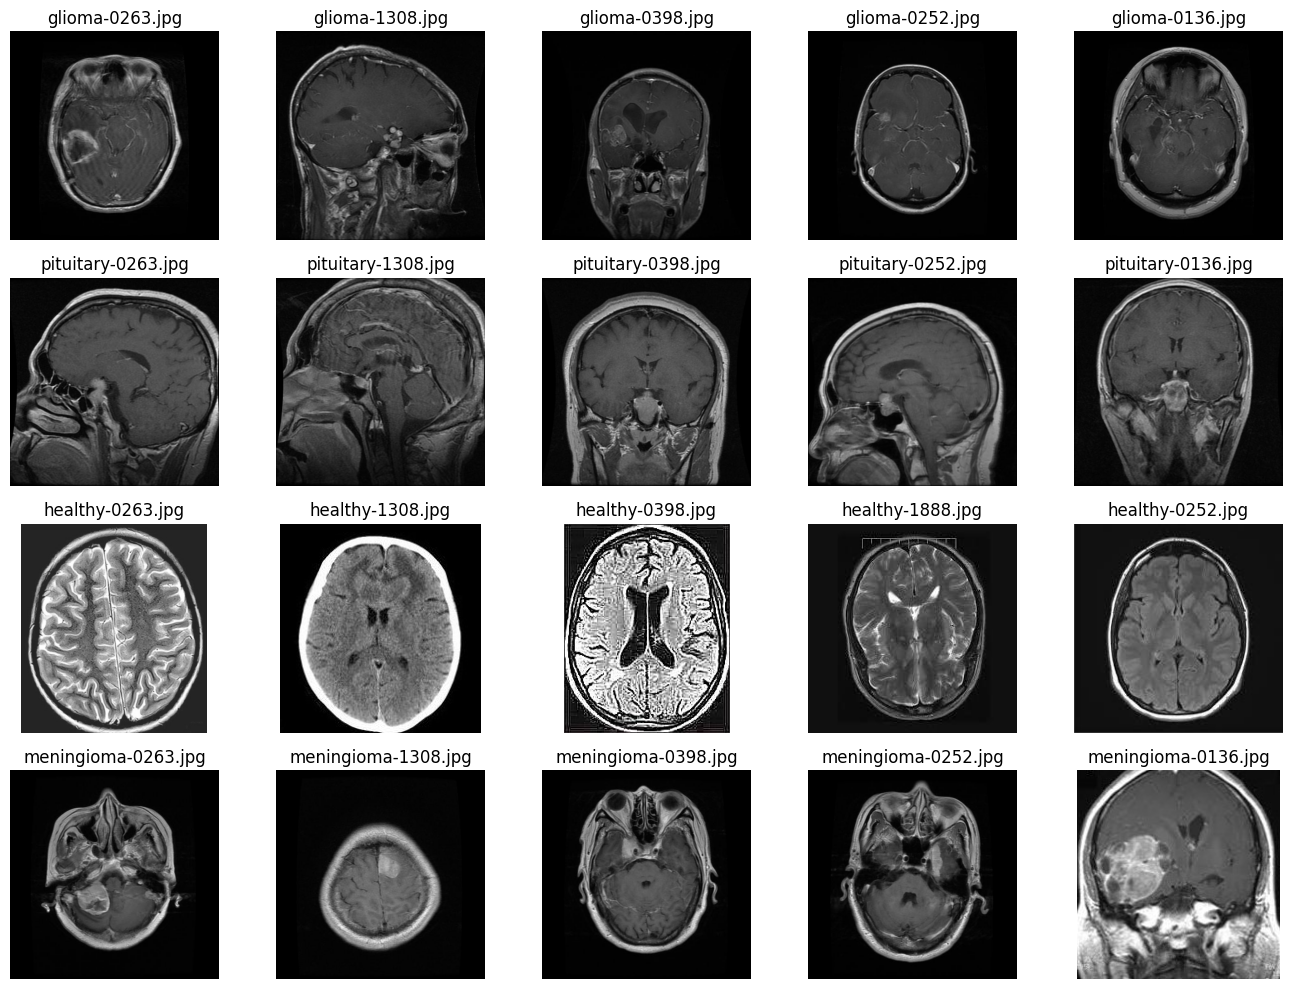

In [ ]:
base_path = dataset_path
plt.figure(figsize=(15, 10))
image_count = 1

for label in classes:
    label_path = os.path.join(dataset_path, label)
    images = os.listdir(label_path)[:5]  # Get the first `num_images` images from the class
    # print(images)
    for img_name in images:
        img_path = os.path.join(label_path, img_name)
        img = Image.open(img_path)
        img_array = np.asarray(img)

        plt.subplot(len(classes), 5, image_count)
        plt.imshow(img_array)
        plt.title(f"{label}-{img_name}")
        plt.axis("off")
        plt.tight_layout()
        image_count += 1

plt.tight_layout()
plt.show()

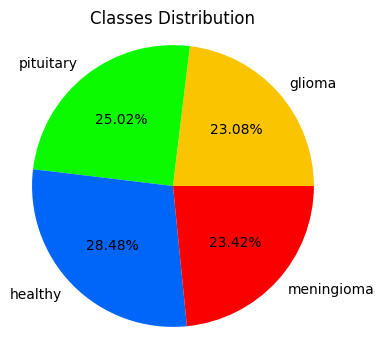

In [ ]:
labels = list(class_counts.keys())
sizes = list(class_counts.values())
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'])
plt.title("Classes Distribution")
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [ ]:
def split_data(base_path, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    train_paths, val_paths, test_paths = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    # Iterate through each class directory
    for label in classes:
        label_path = os.path.join(base_path, label)
        image_paths = [os.path.join(label_path, file) for file in os.listdir(label_path)]
        # print(image_paths)
        labels = [label] * len(image_paths)

        # Split into train and temp (validation + test)
        train_x, temp_x, train_y, temp_y = train_test_split(image_paths, labels, test_size=(1 - train_ratio), random_state=42)

        # Further split temp into validation and test
        val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

        # Add to respective lists
        train_paths.extend(train_x)
        val_paths.extend(val_x)
        test_paths.extend(test_x)
        train_labels.extend(train_y)
        val_labels.extend(val_y)
        test_labels.extend(test_y)

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# Base path for dataset
dataset_path = "brain-tumor-mri-scans"

# Split data
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = split_data(dataset_path)

# Print sizes of each dataset
print(f"Training Set: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")
print(f"Test Set: {len(test_data)} images")

Training Set: 4213 images
Validation Set: 1404 images
Test Set: 1406 images


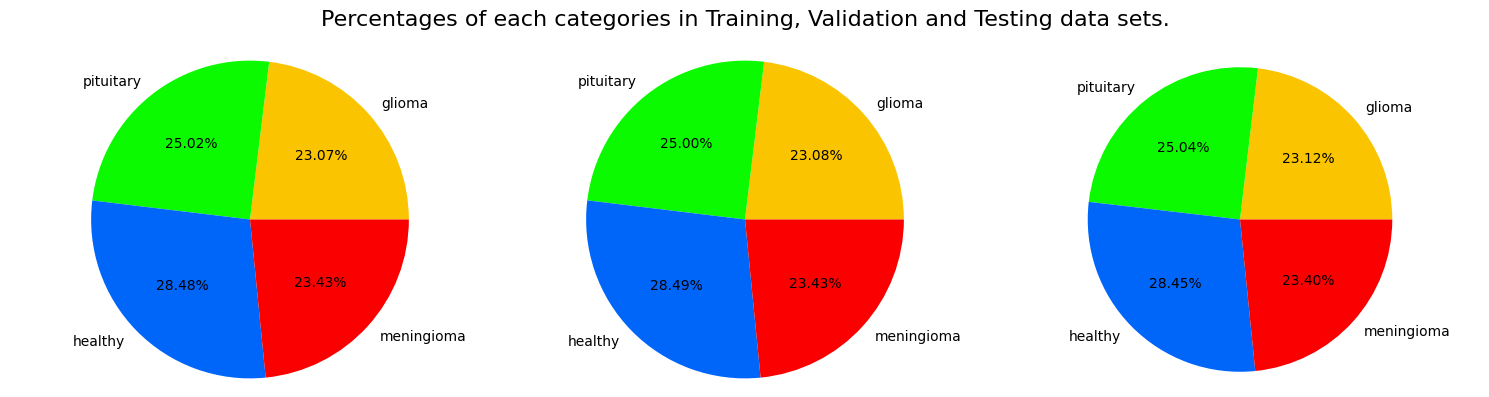

In [ ]:
plt.figure(figsize=(15, 4))
for i, label in enumerate([train_labels, val_labels, test_labels]):
  total=len(label)
  counts = dict(Counter(label))
  plt.subplot(1, 3, i+1)
  plt.pie(counts.values(), labels = counts.keys(), autopct='%1.2f%%', colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'])
  plt.axis("equal")

  plt.suptitle("Percentages of each categories in Training, Validation and Testing data sets.", fontsize=16) # Set a title for the whole plot
  plt.tight_layout()

In [ ]:
# Parameters
image_dim = (168, 168)  # Resize dimensions
batch_size = 32
num_classes = len(classes)

# Preprocessing Function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image, label)
    return image, label


# Convert labels to integers
class_mappings = {'glioma': 0, 'meningioma': 1, 'healthy': 2, 'pituitary': 3}

train_labels_int = [class_mappings[label] for label in train_labels]
val_labels_int = [class_mappings[label] for label in val_labels]
test_labels_int = [class_mappings[label] for label in test_labels]

# Create TensorFlow datasets
def create_dataset(image_paths, labels):
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    # print(labels_one_hot)
    # print(labels_one_hot.shape)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_one_hot))
    # print(dataset)
    dataset = dataset.map(preprocess_image)
    # dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_data, train_labels_int)
val_ds = create_dataset(val_data, val_labels_int)
test_ds = create_dataset(test_data, test_labels_int)
print(train_ds)
print(val_ds)
print(test_ds)

Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8) Tensor("args_1:0", shape=(4,), dtype=float64)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8) Tensor("args_1:0", shape=(4,), dtype=float64)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8) Tensor("args_1:0", shape=(4,), dtype=float64)
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>


In [ ]:
for image, label in train_ds.take(1):  # Take one batch from the dataset
    print("Image Matrix:")
    print(image.numpy())  # Convert tensor to NumPy array and print the matrix
    print("Image Shape:", image.shape)
    print("Label Data:", label.numpy())

Image Matrix:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Image Shape: (512, 512, 3)
Label Data: [1. 0. 0. 0.]


In [ ]:
IM_SIZE = 168
BATCH_SIZE = 32

def resize_rescale(image, label):
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) / 255.0  # Normalize image
    return image, label
 #dividing by 255 is normalization. Actually it is a min-max scaling

In [ ]:
from numpy import random

def augment(image, label):
    image, label = resize_rescale(image, label)  # Resizing and rescaling
    x = random.choice([0,1])

    if x == 0:
      image = tf.image.flip_left_right(image)
    else:
      image = tf.image.flip_up_down(image)

    x = random.choice([1, 3, -2])

    image = tf.image.rot90(image, k = x)  # Rotate 90 or 180 or 270 degrees based on the value of x
    image = tf.image.flip_left_right(image)  # Flip horizontally
    return image, label


In [ ]:
train_dataset = (
    train_ds
    .map(augment)
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [ ]:
val_dataset = (
    val_ds
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

## Callbacks

### Early Stopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True  # Restore the weights of the best epoch
)

### Learning rate scheduler

In [ ]:
def scheduler(epoch, lr):

  if epoch <= 5:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.01)
    learning_rate = learning_rate.numpy()

  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

## Model Training

In [ ]:
# Define a Neural Network Model
dropout_rate = 0.3
IM_SIZE = 168
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    MaxPool2D(pool_size=3, strides=5),

    Flatten(),

    Dense(1000, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(500, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(250, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(100, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(50, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(num_classes, activation='softmax')
])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 166, 166, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 166, 166, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 83, 83, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 83, 83, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 81, 81, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 81, 81, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 38, 38, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 36, 36, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 36, 36, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 34, 34, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 34, 34, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │              

 Total params: 1,456,992 (5.56 MB)

 Trainable params: 1,453,052 (5.54 MB)

 Non-trainable params: 3,940 (15.39 KB)

In [ ]:
dropout_rate = 0.3
IM_SIZE = 168

model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),

    # First block
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    Dropout(dropout_rate),

    # Second block
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    Dropout(dropout_rate),

    # Third block
    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    Dropout(dropout_rate),

    # Fourth block
    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    Dropout(dropout_rate),

    Flatten(),

    # Dense layers
    Dense(512, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(256, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(128, activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 168, 168, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 168, 168, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 168, 168, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 84, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 84, 84, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 84, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 21, 21, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 21, 21, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,450,212 (55.12 MB)

 Trainable params: 14,447,460 (55.11 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy, F1Score

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1')]

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = CategoricalCrossentropy(),
    metrics = metrics,
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    verbose = 1,
    callbacks = [scheduler_callback, es_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1424s 11s/step - accuracy: 0.6685 - auc: 0.4973 - f1: 0.1832 - fn: 1749.1428 - fp: 1118.3534 - loss: 17.2191 - precision: 0.2708 - recall: 0.1930 - tn: 5312.4287 - tp: 394.4511 - val_accuracy: 0.7500 - val_auc: 0.4952 - val_f1: 0.0937 - val_fn: 1404.0000 - val_fp: 0.0000e+00 - val_loss: 16.3644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 4212.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
 34/132 ━━━━━━━━━━━━━━━━━━━━ 15:38 10s/step - accuracy: 0.6716 - auc: 0.4965 - f1: 0.1040 - fn: 465.4118 - fp: 269.4118 - loss: 16.4814 - precision: 0.2595 - recall: 0.1694 - tn: 1410.5883 - tp: 94.5882

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])


## Model Evaluation

In [ ]:
# Apply the preprocessing function to the test dataset
test_dataset = test_ds.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check the shape of the test dataset to confirm it matches the train dataset
for images, labels in test_dataset.take(1):
    print("Test Images Shape:", images.shape)
    print("Test Labels Shape:", labels.shape)


In [ ]:
test_dataset

In [ ]:
# Assuming your model returns these values: loss, accuracy, auc, fn, fp, precision, recall, tn, tp
results = model.evaluate(test_dataset)

# Unpack all the returned values
loss, accuracy, auc, f1, fn, fp, precision, recall, tn, tp = results

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")
print(f"Test F1 Score: {f1}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test False Negatives (fn): {fn}")
print(f"Test False Positives (fp): {fp}")
print(f"Test True Negatives (tn): {tn}")
print(f"Test True Positives (tp): {tp}")


In [ ]:
# Predict on the test dataset
predictions = model.predict(test_dataset)

# Print the predictions
print("Predictions:", predictions)


In [ ]:
for prediction in predictions:
    print(prediction.sum())

In [ ]:
class_mappings = {0: 'glioma', 1: 'meningioma', 2: 'healthy', 3: 'pituitary'}


# Function to map the predicted class index to a human-readable label
def get_predicted_class_text(prediction):
    predicted_class_index = np.argmax(prediction)  # Get the index of the highest probability
    return class_mappings[predicted_class_index]  # Map the index to the class label

def get_actual_class_text(true_label):
    return class_mappings[np.argmax(true_label)]

# Sample code to generate text output based on prediction
def generate_text_output(test_dataset):
    # Predict on the test dataset
    predictions = model.predict(test_dataset)
    actual_labels = np.concatenate([y for x, y in test_dataset], axis=0)

    for i, (prediction, true_label) in enumerate(zip(predictions, actual_labels)):
            predicted_label = get_predicted_class_text(prediction)
            actual_label = get_actual_class_text(true_label)
            print(f"Sample {i + 1}: Predicted class is '{predicted_label}', Actual class is '{actual_label}'")


# Example: Use this function on your test dataset
generate_text_output(test_dataset)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the confusion matrix
def generate_confusion_matrix(test_dataset):
    # Predict on the test dataset
    predictions = model.predict(test_dataset)

    # Get predicted class indices
    predicted_labels = np.argmax(predictions, axis=1)

    # Get actual class indices
    actual_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    actual_labels = np.argmax(actual_labels, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mappings.values()))
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Example: Use this function on your test dataset
generate_confusion_matrix(test_dataset)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the confusion matrix
def generate_confusion_matrix(test_dataset):
    # Predict on the test dataset
    predictions = model.predict(test_dataset)

    # Get predicted class indices
    predicted_labels = np.argmax(predictions, axis=1)

    # Get actual class indices
    actual_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    actual_labels = np.argmax(actual_labels, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mappings.values()))
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Example: Use this function on your test dataset
generate_confusion_matrix(test_dataset)
